# Feature Importance & Skalowanie & Kodowanie & Strojenie hiperparametrów modeli

## 1. Ładowanie danych oraz potrzebnych bibliotek

In [1]:
# Pakiety
import pandas as pd 
import numpy as np

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from joblib import dump, load

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score

np.random.seed(123) 

# Wczytywanie danych
data = pd.read_csv('german_credit_data_dataset.csv')
data = pd.DataFrame(data)

/home/elzbieta/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Kolumny z danymi numerycznymi
num = data.select_dtypes(include=['float64', 'int']).drop('customer_type', axis = 1).columns

# Kolumny z danymi kategorycznymi
cat = data.select_dtypes(include=['object']).columns.tolist()

## 2. Skalowanie danych numerycznych

In [4]:
scaler = StandardScaler()
scaled = data.copy()
scaled[num] = scaler.fit_transform(data[num])

## 3. Podział na zbiory trenigowe i testowe

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop('customer_type', axis=1), data['customer_type'])
scaled_X_train, scaled_X_test, scaled_Y_train, scaled_Y_test = train_test_split(scaled.drop('customer_type', axis=1), scaled['customer_type'])

## 4. Encoding

### 4.1. One-Hot Encoding

In [6]:
ohe = ce.OneHotEncoder(data, cols = cat)

# Ramka zakodowana nieskalowana
ohe_train = ohe.fit_transform(X = X_train, y = Y_train)
ohe_test = ohe.transform(X_test)

# Ramka zakodowana, przeskalowana
ohe_scaled_train = ohe.fit_transform(X = scaled_X_train, y = scaled_Y_train)
ohe_scaled_test = ohe.transform(scaled_X_test)

df = pd.DataFrame(ohe_train, Y_train)

### 4.2. Target Encoding

In [7]:
te = ce.TargetEncoder(cols = cat)

# Ramka zakodowana nieskalowana
te_train = te.fit_transform(X = X_train, y = Y_train)
te_test = te.transform(X_test)

# Ramka zakodowana, przeskalowana
te_scaled_train = te.fit_transform(X = scaled_X_train, y = scaled_Y_train)
te_scaled_test = te.transform(scaled_X_test)

### 4.3. James Stein Encoding

In [8]:
js = ce.JamesSteinEncoder(cols = cat)

# Ramka zakodowana nieskalowana
js_train = js.fit_transform(X = X_train, y = Y_train)
js_test = js.transform(X_test)

# Ramka zakodowana, przeskalowana
js_scaled_train = js.fit_transform(X = scaled_X_train, y = scaled_Y_train)
js_scaled_test = js.transform(scaled_X_test)

### 4.4. Polynomial Encoding

In [9]:
pe = ce.PolynomialEncoder(cols = cat)

# Ramka zakodowana nieskalowana
pe_train = pe.fit_transform(X = X_train, y = Y_train)
pe_test = pe.transform(X_test)

# Ramka zakodowana, przeskalowana
pe_scaled_train = pe.fit_transform(X = scaled_X_train, y = scaled_Y_train)
pe_scaled_test = pe.transform(scaled_X_test)

## 5. Strojenie modeli

### 5.1. Random Forest  
Hiperparametry:  

- **n_estimators** - ilość drzew składowych (int, domyślnie 100)  
- **criterion** - funkcja miary jakości podziału (string, domyślnie gini)  
- **max_depth** - maksymalna głębokość drzewa (int, domyślnie None)   
- **min_samples_split** - minimalna liczba obserwacji wymagana do podziału węzła wewnętrznego (int/float, domyślnie 2)  
- **min_samples_leaf** - minimalna liczba obserwacji wymagana względem liścia (int, domyślnie 1)  
- **min_weight_fraction_leaf** - minimalna frakcja wag wymagana względem liścia (domyślnie 0)  
- **max_features** - ilość cech branych pod uwagę podczas poszukiwania najlepszego podziału (string). Jeśli “sqrt”, to max_features=sqrt(n_features), jeśli “log2”, to max_features=log2(n_features).  
- **max_leaf_nodes** - maksymalna liczba liści (int, domyślnie None)  
- **min_impurity_decrease** - węzeł zostanie podzielony, jeśli podział ten spowoduje zmniejszenie miary impurity większe lub równe tej wartości. (float, domyślnie 0)  
- **min_impurity_split** - próg zatrzymania wzrostu drzew. Węzeł rozdzieli się, jeśli jego impurity przekroczy próg, w przeciwnym razie będzie liściem. (float, default 1e-7)  
- **bootstrap** - stosowanie bootstrap (bool, domyślnie True)  
- **oob_score** - gdy zestaw treningowy dla bieżącego drzewa jest rysowany przez próbkowanie z wymianą, około jedna trzecia przypadków jest pomijana. Te dane OOB są używane do uzyskania bezstronnego oszacowania błędu klasyfikacji (bool, domyślnie False)  
- **oob_score** - liczba powtórzeń instukcji fit, predict, ect.  
- **random_state** - kontroluje losowość procedury bootstrap   
- **verbose** - int, domyślnie 0 - im wyższa liczba tym więcej informacji uzyskami na temat procedur fit i predict  
- **warm_start** - po ustawieniu wartości True ponownie użyje bieżącego rozwiązania, aby dopasować i dodać więcej estymatorów do zestawu, w przeciwnym razie po prostu zmieni cały nowy las. (bool, domyślnie False)  
- **ccp_alpha** - dotyczy przycinania, zostanie wybrane poddrzewo o największym koszcie, który jest mniejszy niż ccp_alpha. Domyślnie 0.0, czyli przycinanie nie jest wykonywane.  
- **max_samples** - dotyczy procedury bootstrap (domyślnie None)

In [10]:
# Funkcja służąca do zbudowania pipeline'a, który w kolejnych krokach będzie miał encoding, scalling oraz 
# klasyfikator - dzięki temu pozbywamy sie dataleak'u przy kroswalidacji, ponieważ dla każdego podziału 
# kroswalidacji będzie wykonywany scalling tylko na zbiorze treningowym, nie biorąc pod uwagę testowego

def makePipeline(cat_indices, num_indices, classificator, encoder, scaled = False):
    
    if scaled == True:
        pipeline = Pipeline(steps = [
        ('feature_processing', FeatureUnion(transformer_list = [
                ('categorical', FunctionTransformer(lambda data: data[cat_indices])),

                #numeric
                ('numeric', Pipeline(steps = [
                    ('select', FunctionTransformer(lambda data: data[num_indices])),
                    ('scale', StandardScaler())
                            ]))
            ])),
        ('encoder', encoder),
        ('classifier', classificator)
        ]
    )
    else:
        pipeline = Pipeline([
        ('encoder', encoder),
        ('classifier', classificator)
        ])
    return pipeline
        

# Funkcja, która zmierzy nam ilość czasu potrzebną na wykonanie danej funkcji

def timer(start_time = None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [41]:
# Model
rf_classifier = RandomForestClassifier()

# Hiperparametry
rf_param_grid =  {'classifier__bootstrap': [True, False],
                 'classifier__max_depth': [3, 5, 6, 7, 10, 15, 20, 30, None],
                 'classifier__max_features': ['auto', 'sqrt', 'log2'],
                 'classifier__min_samples_leaf': [1, 2, 3, 4],
                 'classifier__min_samples_split': [2, 3, 5, 10],
                 'classifier__n_estimators': [50, 100, 150, 200, 250, 400, 600, 800, 1000]}

In [42]:
# One-Hot Encoding & Random Forest
rf_ohe_pipeline = makePipeline(cat, num, rf_classifier, ce.OneHotEncoder(), False)

rf_ohe_random_search = RandomizedSearchCV(rf_ohe_pipeline, param_distributions = rf_param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = -1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
rf_ohe_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minęło od start_time
print(rf_ohe_random_search.best_score_)
print(rf_ohe_random_search.best_params_)


 Time taken: 0 hours 26 minutes and 12.61 seconds.
0.7725262853962316
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None, 'classifier__bootstrap': True}


In [43]:
# One-Hot Encoding & Skalowanie & Random Forest

rf_ohe_scaled_random_search = RandomizedSearchCV(rf_ohe_scaled_pipeline, param_distributions = rf_param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = -1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
rf_ohe_scaled_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minęło od start_time
print(rf_ohe_scaled_random_search.best_score_)
print(rf_ohe_scaled_random_search.best_params_)


 Time taken: 0 hours 26 minutes and 13.05 seconds.
0.7724704861311752
{'classifier__n_estimators': 800, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 3, 'classifier__max_features': 'log2', 'classifier__max_depth': 6, 'classifier__bootstrap': True}


In [44]:
# Target Encoding & Random Forest
rf_target_pipeline = makePipeline(cat, num, rf_classifier, ce.TargetEncoder(), False)

rf_target_random_search = RandomizedSearchCV(rf_target_pipeline, param_distributions = rf_param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = -1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
rf_target_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minęło od start_time
print(rf_target_random_search.best_score_)
print(rf_target_random_search.best_params_)


 Time taken: 0 hours 26 minutes and 58.09 seconds.
0.7779681257299945
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'auto', 'classifier__max_depth': 7, 'classifier__bootstrap': True}


In [45]:
# Target Encoding & Skalowanie & Random Forest
rf_target_scaled_pipeline = makePipeline(cat, num, rf_classifier, ce.TargetEncoder(), True)

rf_target_scaled_random_search = RandomizedSearchCV(rf_target_scaled_pipeline, param_distributions = rf_param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = -1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
rf_target_scaled_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minęło od start_time
print(rf_target_scaled_random_search.best_score_)
print(rf_target_scaled_random_search.best_params_)


 Time taken: 0 hours 26 minutes and 41.99 seconds.
0.769522808636947
{'classifier__n_estimators': 200, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 3, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__bootstrap': True}


### 5.2. XGBoost

Hiperparametry:  

- **n_estimators** - ilość drzew składowych (int, domyślnie 100)
- **max_depth** - maksymalna głebokość drzewa, im większa wartość tym bardziej skompikowany model - moze prowadzic do overfittingu (int, domyslnie 6)
- **min_child_weight** - minimalna waga, wymagana względem węzła potomnego (domyślnie 1)
- **gamma** - minimalna "loss reduction" do przeprowadzenia dalszego podziału liscia (domyślnie 0)
- **subsample** - frakcja danych do próbkowania przed tworzeniem drzewa, tak aby uniknac overfittingu (domyslnie 1)
- **colsample_bytree** - frakcja kolumn wzięta do towrzenia każdego z drzew (domyślnie 1)
- **learning_rate** - im mniejsza wartość tym mniejsze kroki nauczania każdego z drzew (domyślnie 0.02)

In [25]:
# Funkcja, która znajduje optymalną ilosć drzew (n_estimators parameter) używając funkcji cv xgboosta dla
# danej wartosci learning_rate i zmienia wartość n_estimators odpowiednio

def modelfit(alg, dtrain, predictors, cv_folds = 5, early_stopping_rounds = 50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'],
                      nfold=cv_folds, metrics='auc', early_stopping_rounds = early_stopping_rounds)
    alg.set_params(n_estimators = cvresult.shape[0])

In [26]:
# Siatka parametrów do strojenia

param_grid = {
    'classifier__max_depth': range (2, 10, 1),
    'classifier__min_child_weight': range(1,10,1),
    'classifier__gamma': [i/10.0 for i in range(0,50,5)],
    'classifier__subsample': [i/100.0 for i in range(50,100,5)],
    'classifier__colsample_bytree': [i/100.0 for i in range(50,100,5)],
    'classifier__learning_rate': [0.0001,0.01,0.1,0.2,0.3],
    'classifier__n_estimators': [50,100,150,300,500,600,700,800,1000]
    }

# Domyślny classifier

xgb_classifier = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=4)


In [27]:
# One-Hot-Encoding & Random
xgb_ohe_pipeline = makePipeline(cat, num, xgb_classifier, ce.OneHotEncoder(), False)

ohe_random_search = RandomizedSearchCV(xgb_ohe_pipeline, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
ohe_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minęło od start_time
print(ohe_random_search.best_score_)
print(ohe_random_search.best_params_)


 Time taken: 0 hours 46 minutes and 16.05 seconds.
0.774461243975972
{'classifier__subsample': 0.6, 'classifier__n_estimators': 700, 'classifier__min_child_weight': 3, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.01, 'classifier__gamma': 1.0, 'classifier__colsample_bytree': 0.75}


In [28]:
# One-Hot-Encoding & Skalowanie & Random
xgb_ohe_scaled_pipeline = makePipeline(cat, num, xgb_classifier, ce.OneHotEncoder(), True)

ohe_scaled_random_search = RandomizedSearchCV(xgb_ohe_scaled_pipeline, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
ohe_scaled_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minęło od start_time
print(ohe_scaled_random_search.best_score_)
print(ohe_scaled_random_search.best_params_)


 Time taken: 0 hours 43 minutes and 41.38 seconds.
0.7750962483731816
{'classifier__subsample': 0.6, 'classifier__n_estimators': 700, 'classifier__min_child_weight': 3, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.01, 'classifier__gamma': 1.0, 'classifier__colsample_bytree': 0.75}


In [29]:
# Target Encoding & Random
xgb_target_pipeline = makePipeline(cat, num, xgb_classifier, ce.TargetEncoder(), False)

target_random_search = RandomizedSearchCV(xgb_target_pipeline, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
target_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minęło od start_time
print(target_random_search.best_score_)
print(target_random_search.best_params_)


 Time taken: 0 hours 31 minutes and 3.44 seconds.
0.7811454404535072
{'classifier__subsample': 0.6, 'classifier__n_estimators': 50, 'classifier__min_child_weight': 3, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 4.5, 'classifier__colsample_bytree': 0.9}


In [30]:
# Target Encoding & Skalowanie & Random
xgb_target_scaled_pipeline = makePipeline(cat, num, xgb_classifier, ce.TargetEncoder(), True)

target_scaled_random_search = RandomizedSearchCV(xgb_target_scaled_pipeline, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
target_scaled_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minęło od start_time
print(target_scaled_random_search.best_score_)
print(target_scaled_random_search.best_params_)


 Time taken: 0 hours 33 minutes and 42.64 seconds.
0.7711405679203901
{'classifier__subsample': 0.95, 'classifier__n_estimators': 600, 'classifier__min_child_weight': 4, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.2, 'classifier__gamma': 2.0, 'classifier__colsample_bytree': 0.75}


## 6. Ewaluacja modeli

In [24]:
## Funkcja prezentująca podsumowanie modelu na danych testowych 
# za pomocą metryk - accuracy, precision, recall oraz wykresu krzywej ROC
def evaluateModel(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_true = Y_test
    print("Accuracy: " + str(accuracy_score(y_true, y_pred, normalize = True)))
    print("Precision: " + str(precision_score(y_true, y_pred, average = 'macro')))
    print("Recall: " + str(recall_score(y_true, y_pred)))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba, pos_label=2)
    print("AUC: " + str(metrics.auc(fpr, tpr)))
#    plt.figure()
#    plt.plot([0, 1], [0, 1], 'k--')
#    plt.plot(fpr, tpr)
#    plt.xlabel('False positive rate')
#    plt.ylabel('True positive rate')
#    plt.title('ROC curve')
#    plt.show()
    
## Funkcja zwracajaca AUC dla modelu testowego
def returnAUC(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_true = Y_test
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba, pos_label=2)
    return metrics.auc(fpr, tpr)

In [46]:
# Zapisujemy modele do zewnętrznych plików, tak aby przy każdym uruchomieniu nie musieć przeprowadzać wszystkich
# czasochłonnych operacji związanych z ich znalezieniem

rf_ohe = rf_ohe_random_search.best_estimator_
#dump(rf_ohe.steps[1], 'rf_ohe.joblib')

rf_ohe_scaled = rf_ohe_scaled_random_search.best_estimator_
#dump(rf_ohe_scaled.steps[2], 'rf_ohe_scaled.joblib') 

rf_target = rf_target_random_search.best_estimator_
#dump(rf_target.steps[1], 'rf_target.joblib') 

rf_target_scaled = rf_target_scaled_random_search.best_estimator_
#dump(rf_target_scaled.steps[2], 'rf_target_scaled.joblib') 

['rf_target_scaled.joblib']

In [40]:
xgb_ohe = ohe_random_search.best_estimator_
#dump(xgb_ohe.steps[1], 'xgb_ohe.joblib') 

xgb_ohe_scaled = ohe_scaled_random_search.best_estimator_
#dump(xgb_ohe_scaled.steps[2], 'xgb_ohe_scaled.joblib') 

xgb_target = target_random_search.best_estimator_
#dump(xgb_target.steps[1], 'xgb_target.joblib') 

xgb_target_scaled = target_scaled_random_search.best_estimator_
#dump(xgb_target_scaled.steps[2], 'xgb_target_scaled.joblib') 

['xgb_target_scaled.joblib']

In [41]:
# tworzymy tabelkę z wynikami dla poszczególnych algorytmów

model = ["rf_ohe","rf_ohe_scaled","rf_target","rf_target_scaled",
        "xgb_ohe", "xgb_ohe_scaled", "xgb_target", "xgb_target_scaled"]
auc_values = []

for i in model:
    current_model = eval(i)
    auc_values.append(returnAUC(current_model, X_train, Y_train, X_test, Y_test))

pd.DataFrame({
    "Model" : model,
    "AUC": auc_values
})

,Model,AUC
0,rf_ohe,0.818452
1,rf_ohe_scaled,0.819614
2,rf_target,0.825203
3,rf_target_scaled,0.828978
4,xgb_ohe,0.812427
5,xgb_ohe_scaled,0.812427
6,xgb_target,0.816057
7,xgb_target_scaled,0.799724


In [47]:
evaluateModel(rf_target, X_train, Y_train, X_test, Y_test)

Accuracy: 0.736
Precision: 0.7214285714285714
Recall: 0.9285714285714286
AUC: 0.8286149825783973


In [48]:
evaluateModel(xgb_target, X_train, Y_train, X_test, Y_test)

Accuracy: 0.772
Precision: 0.755944055944056
Recall: 0.9107142857142857
AUC: 0.8160569105691057


In [49]:
evaluateModel(rf_target_scaled, X_train, Y_train, X_test, Y_test)

Accuracy: 0.74
Precision: 0.7200542005420054
Recall: 0.9166666666666666
AUC: 0.8344947735191638


In [50]:
evaluateModel(xgb_target_scaled, X_train, Y_train, X_test, Y_test)

Accuracy: 0.752
Precision: 0.7228070175438597
Recall: 0.8809523809523809
AUC: 0.7997241579558653


In [103]:
# Funkcja rysująca wykres krzywej ROC dla podanych modeli (niestety nazwy trzeba podać ręcznie)

def plotROC(X_train, Y_train, X_test, Y_test, names, *models):
    fpr_list = []
    trp_list = []
    k = 0
    for i in models:
        i.fit(X_train, Y_train)
        y_pred = i.predict(X_test)
        y_proba = i.predict_proba(X_test)[:, 1]
        y_true = Y_test
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba, pos_label=2)
        fpr_list.append(fpr)
        trp_list.append(tpr)
        k += 1
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(len(fpr_list)):
        plt.plot(fpr_list[i], trp_list[i], label = names[i])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='best')
    plt.title('ROC curve')
    plt.savefig("ROCboth.png")
    plt.show()
    

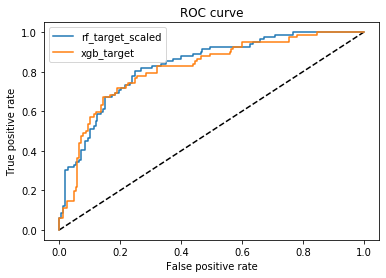

In [104]:
names = ["rf_target_scaled", "xgb_target"]
plotROC(X_train, Y_train, X_test, Y_test, names, rf_target_scaled, xgb_target)

Skoro już tyle czasu poświęciliśmy na dostrojenie parametrów, zobaczmy jaka jest róznica pomiedzy modelami niestrojonymi, a strojonymi. Tutaj również wykorzystamy do tego miarę AUC. 

In [47]:
rf_default_classifier = RandomForestClassifier()
xgb_default_classifier = xgb.XGBClassifier()

# domyślny rf
rf_default_ohe = makePipeline(cat, num, rf_default_classifier, ce.OneHotEncoder(), False)
rf_default_ohe_scaled = makePipeline(cat, num, rf_default_classifier, ce.OneHotEncoder(), True)
rf_default_target = makePipeline(cat, num, rf_default_classifier, ce.TargetEncoder(), False)
rf_default_target_scaled = makePipeline(cat, num, rf_default_classifier, ce.TargetEncoder(), True)

# domyślny xgb
xgb_default_ohe = makePipeline(cat, num, xgb_default_classifier, ce.OneHotEncoder(), False)
xgb_default_ohe_scaled = makePipeline(cat, num, xgb_default_classifier, ce.OneHotEncoder(), True)
xgb_default_target = makePipeline(cat, num, xgb_default_classifier, ce.TargetEncoder(), False)
xgb_default_target_scaled = makePipeline(cat, num, xgb_default_classifier, ce.TargetEncoder(), True)

# skalowany rf (wczytujemy z plikow ktore stworzylismy)
rf_ohe = makePipeline(cat, num, load('rf_ohe.joblib')[1], ce.OneHotEncoder(), False)
rf_ohe_scaled = makePipeline(cat, num, load('rf_ohe_scaled.joblib')[1], ce.OneHotEncoder(), True)
rf_target = makePipeline(cat, num, load('rf_target.joblib')[1], ce.TargetEncoder(), False)
rf_target_scaled = makePipeline(cat, num, load('rf_target_scaled.joblib')[1], ce.TargetEncoder(), True)

# skalowany xgb
xgb_ohe = makePipeline(cat, num, load('xgb_ohe.joblib')[1], ce.OneHotEncoder(), False)
xgb_ohe_scaled = makePipeline(cat, num, load('xgb_ohe_scaled.joblib')[1], ce.OneHotEncoder(), True)
xgb_target = makePipeline(cat, num, load('xgb_target.joblib')[1], ce.TargetEncoder(), False)
xgb_target_scaled = makePipeline(cat, num, load('xgb_target_scaled.joblib')[1], ce.TargetEncoder(), True)

In [49]:
models = ["rf_ohe","rf_ohe_scaled","rf_target","rf_target_scaled",
        "xgb_ohe", "xgb_ohe_scaled", "xgb_target", "xgb_target_scaled"]
auc_values = []

models_not_tuned = ["rf_default_ohe","rf_default_ohe_scaled","rf_default_target","rf_default_target_scaled",
        "xgb_default_ohe", "xgb_default_ohe_scaled", "xgb_default_target", "xgb_default_target_scaled"]
auc_values_not_tuned = []

for i in models:
    current_model = eval(i)
    auc_values.append(returnAUC(current_model, X_train, Y_train, X_test, Y_test))
    
for i in models_not_tuned:
    current_model = eval(i)
    auc_values_not_tuned.append(returnAUC(current_model, X_train, Y_train, X_test, Y_test))

pd.DataFrame({
    "Model" : models,
    "AUC_not_tuned": auc_values_not_tuned,
    "AUC_tuned": auc_values
})

,Model,AUC_not_tuned,AUC_tuned
0,rf_ohe,0.831119,0.831301
1,rf_ohe_scaled,0.834495,0.828978
2,rf_target,0.813879,0.820630
3,rf_target_scaled,0.830611,0.830430
4,xgb_ohe,0.799361,0.812427
5,xgb_ohe_scaled,0.803354,0.812427
6,xgb_target,0.806693,0.816057
7,xgb_target_scaled,0.802773,0.799724


Widzimy, że poza nielicznymi wyjątkami modele po strojeniu hiperparamterów poradziły sobie lepiej na danych testowych.

## 7. Feature importance


Najpierw sprawdzę wage zmiennych dla xgb i RandomForest.




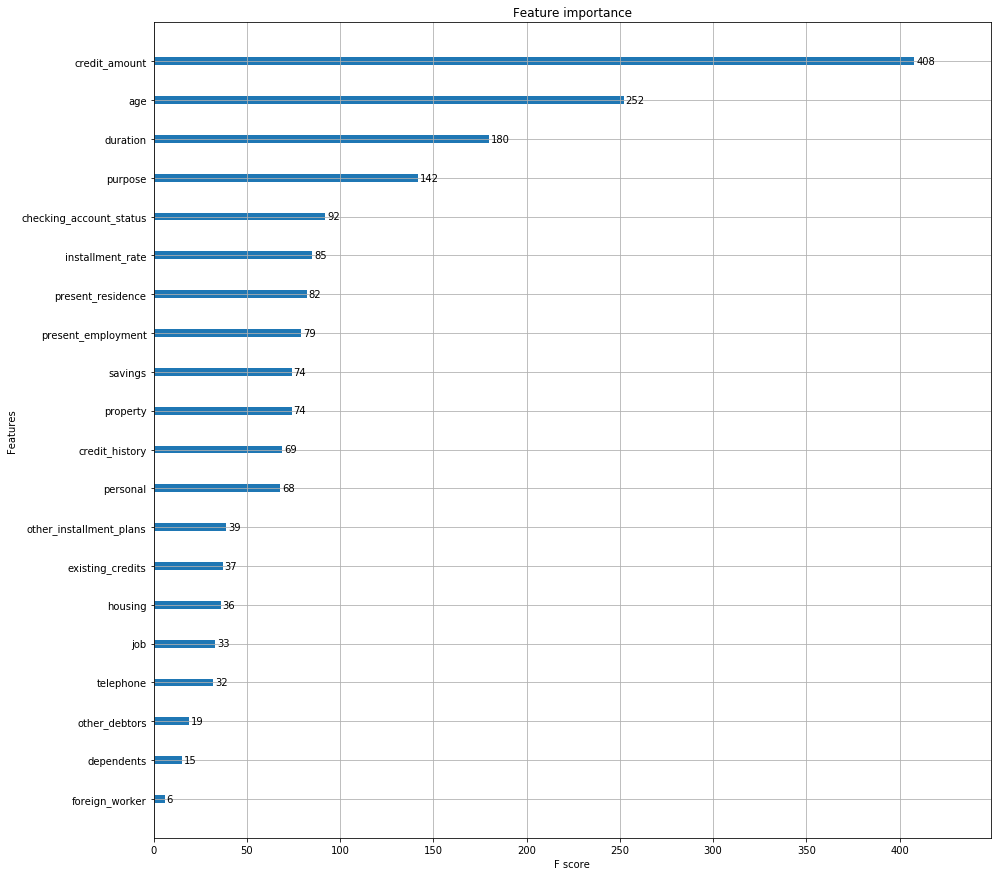

In [7]:
# Feature importance dla xgb 
from xgboost import plot_importance
from matplotlib import pyplot
plt.rcParams['figure.figsize'] = [15, 15]

# Targer encoding 
xgb_test = xgb.XGBClassifier()
xgb_test.fit(te_scaled_train,scaled_Y_train)
plot_importance(xgb_test)

Najważniejszą zminną jest credit_ammount a zminne numeryczne wydają się mieć większą wagę niż te kategoryczne

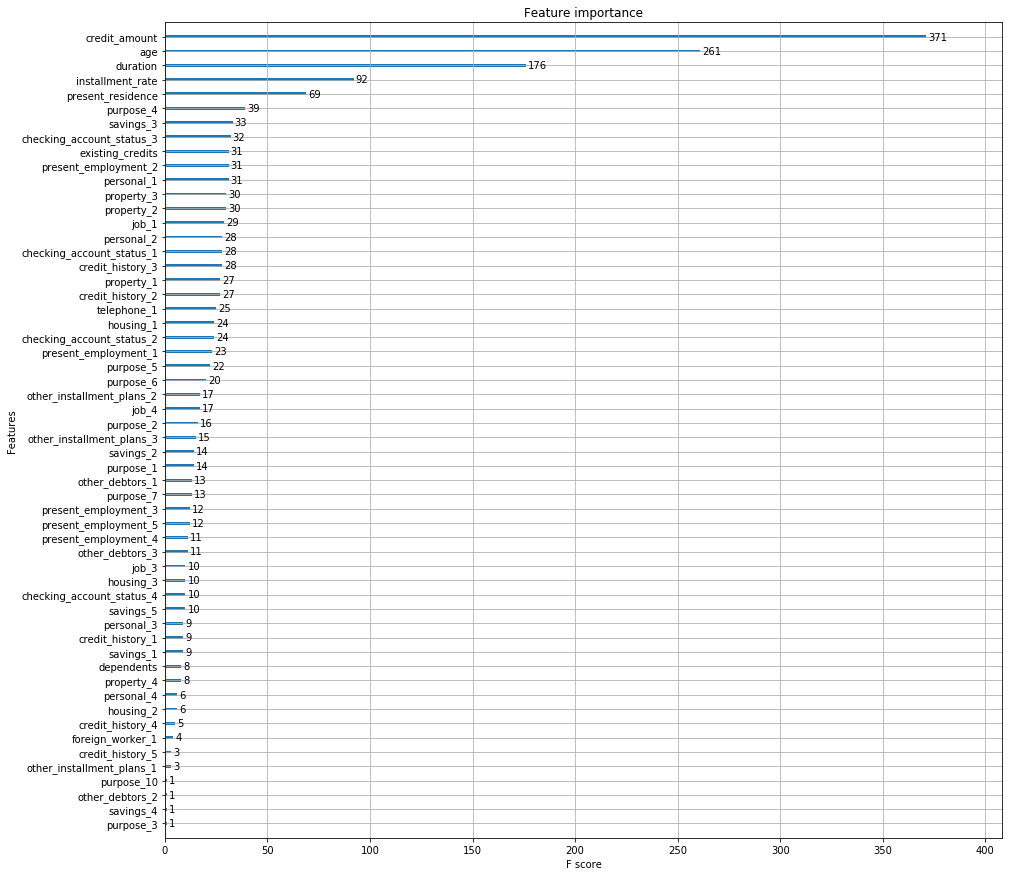

In [8]:
# One-Hot Encoding 
xgb_test_oh = xgb.XGBClassifier()
xgb_test_oh.fit(ohe_scaled_train,scaled_Y_train)
plot_importance(xgb_test_oh)

5 najważniejszych zmiennych to zmienne numeryczne co nie dziwi ponieważ po one hocie każda kolumna zmienna kategoryczna została rozbita na kilka kolumn.

Można zauważyć ,że XGB przywiązuje większą wagę do zminnych numerycznych niż kategorycznych. 

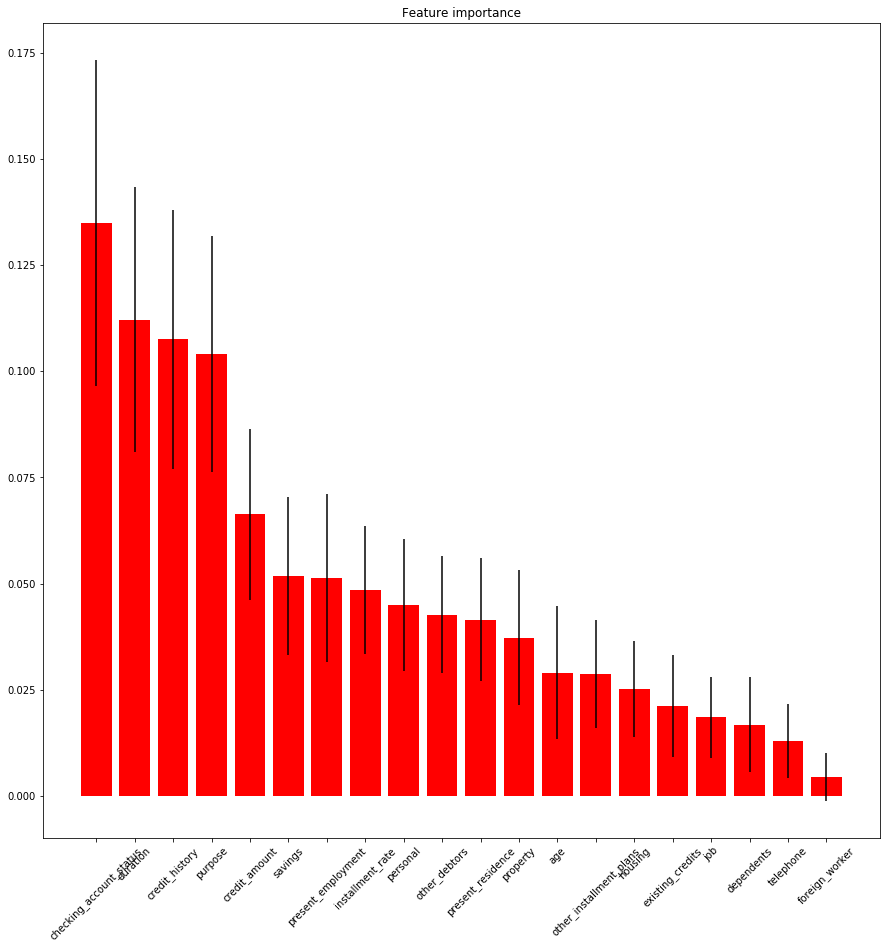

In [9]:
# Feature importance RandomForest

#Target encoding
rf_test = RandomForestClassifier()
rf_test.fit(te_scaled_train,scaled_Y_train)


importances = rf_test.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_test.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


plt.figure()
plt.title("Feature importance")
plt.bar(X_train.columns, importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(rotation=45)
plt.show()

Wyniki zupełnie inne niż w przypadku XGB tym razem najważniejsza zmienna jest kategoryczna  i jest znacznie ważniejsza niż następna w kolejności. Kolumny ważne dla XGB np.age znacznie straciły na ważności.

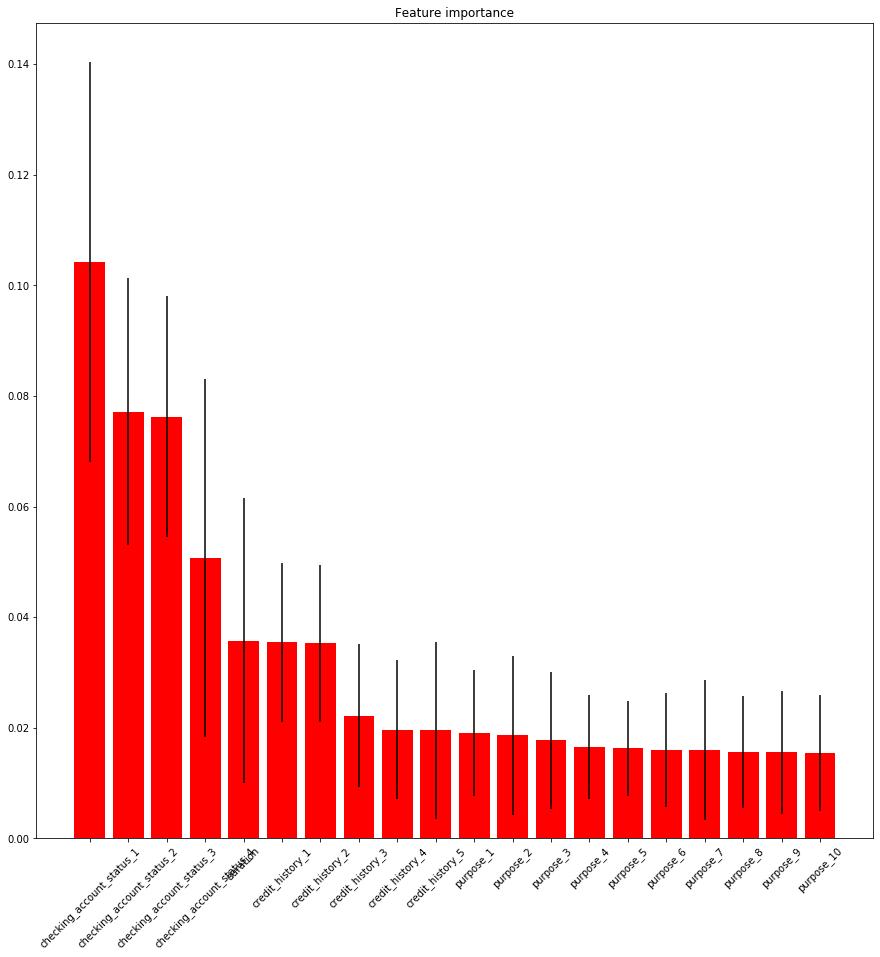

In [10]:
# One-Hot Encoding 
rf_test = RandomForestClassifier()
rf_test.fit(ohe_scaled_train,scaled_Y_train)

importances = rf_test.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_test.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


plt.figure()
plt.title("Feature importance")
plt.bar(ohe_scaled_train.columns[:20], importances[indices][:20],
       color="r", yerr=std[indices][:20], align="center")
plt.xticks(rotation=45)
plt.show()


Wykres dla 20 najważniejszych zmiennych pomijając rozbicie zmiennych kategorycznych na kolumny wykres podobny do poprzedniego

In [25]:
# Wybór najlepszych zmiennych przy użyciu algorytmu Boruta 
# 
# XGB target
from boruta import BorutaPy
from sklearn.model_selection import cross_val_score
def test(X_train,X_test,model):

    
    

    feat_selector = BorutaPy(model, n_estimators='auto',random_state=1)
    feat_selector.fit(X_train.values,scaled_Y_train)


    # feature ranking
    a=feat_selector.support_
    ranking=feat_selector.ranking_
    print(ranking)

    def checking(X_train,X_test,a,ranking,model):
        for i in range(1,max(ranking)+1):
    
            data_test = ranking<=i
            
            cv_score=cross_val_score(model,X_train.iloc[:,data_test],scaled_Y_train,cv=5,n_jobs=-1)
            print(f"Treschold: {i}   CV_score_mean:  {round(np.mean(cv_score),3)} Cv_score_std {round(np.std(cv_score),3)}")


    checking(X_train,X_test,a,ranking,model)
    return ranking
rn=test(te_scaled_train,te_scaled_test,xgb.XGBClassifier())
    

[ 1  1  1  2  7  1  4  7 12  1 11  7 10  1  3 15  9  5 14 12]
Treschold: 1   CV_score_mean:  0.72 Cv_score_std 0.031
Treschold: 2   CV_score_mean:  0.743 Cv_score_std 0.026
Treschold: 3   CV_score_mean:  0.727 Cv_score_std 0.021
Treschold: 4   CV_score_mean:  0.716 Cv_score_std 0.026
Treschold: 5   CV_score_mean:  0.711 Cv_score_std 0.025
Treschold: 6   CV_score_mean:  0.711 Cv_score_std 0.025
Treschold: 7   CV_score_mean:  0.733 Cv_score_std 0.039
Treschold: 8   CV_score_mean:  0.733 Cv_score_std 0.039
Treschold: 9   CV_score_mean:  0.739 Cv_score_std 0.035
Treschold: 10   CV_score_mean:  0.756 Cv_score_std 0.009
Treschold: 11   CV_score_mean:  0.768 Cv_score_std 0.022
Treschold: 12   CV_score_mean:  0.76 Cv_score_std 0.026
Treschold: 13   CV_score_mean:  0.76 Cv_score_std 0.026
Treschold: 14   CV_score_mean:  0.757 Cv_score_std 0.032
Treschold: 15   CV_score_mean:  0.765 Cv_score_std 0.031


Najlepszy rezultat jest uzyskiwany dla th=11 ale wynik jest bardzo zbliżony do wszystkich zmiennych. Najlepsze kolumny:

In [26]:
te_scaled_train.iloc[:,rn<=11]


,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,other_debtors,present_residence,property,age,other_installment_plans,housing,job,dependents
703,1.398936,0.754763,1.307692,1.380282,-0.272304,1.285714,1.256684,0.918477,1.304412,-0.765977,1.310734,0.479693,1.382353,1.259813,1.293996,-0.428290
53,1.119355,-0.240857,1.337469,1.205128,0.037834,1.183099,1.304688,-0.870183,1.304412,-1.672459,1.310734,-0.399832,1.273171,1.259813,1.293996,-0.428290
438,1.497537,1.750384,1.173333,1.266667,0.043505,1.369469,1.384615,0.918477,1.333333,1.046987,1.299595,2.590552,1.273171,1.259813,1.250000,-0.428290
670,1.119355,0.256953,1.173333,1.380282,0.307565,1.285714,1.304688,0.024147,1.304412,0.140505,1.310734,-0.751642,1.273171,1.259813,1.285714,-0.428290
113,1.119355,1.252574,1.173333,1.386740,1.624677,1.369469,1.304688,0.918477,1.304412,-0.765977,1.231132,-0.927547,1.382353,1.259813,1.293996,-0.428290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,1.497537,-0.738668,1.337469,1.386740,-0.890453,1.369469,1.201613,0.918477,1.304412,-0.765977,1.231132,-0.839594,1.273171,1.259813,1.293996,-0.428290
176,1.497537,-0.738668,1.337469,1.300752,-0.246075,1.369469,1.304688,-0.870183,1.304412,-1.672459,1.299595,0.567645,1.273171,1.259813,1.293996,-0.428290
108,1.497537,0.256953,1.337469,1.300752,1.577182,1.183099,1.412214,-1.764514,1.304412,-0.765977,1.310734,-0.487784,1.273171,1.259813,1.293996,-0.428290
516,1.497537,-1.236478,1.173333,1.386740,-0.677078,1.369469,1.412214,-0.870183,1.304412,1.046987,1.231132,0.391740,1.273171,1.259813,1.285714,2.334869


In [27]:
# Xgb one hote encoding 
ranking=test(ohe_scaled_train,ohe_scaled_test,xgb.XGBClassifier())



[42  1 25  1  8 27 17 18 14  3  6 22 52 28 30 32  9 55 55 55 22 35 34  4
 29  1 36 50  4 19  9 36 46 45 15  2 25 51  1 42 13 40 32 19 40  6 11 21
 24 32 44 49 39 55 47 12 38 47 55 16 55]
Treschold: 1   CV_score_mean:  0.7 Cv_score_std 0.0
Treschold: 2   CV_score_mean:  0.709 Cv_score_std 0.003
Treschold: 3   CV_score_mean:  0.709 Cv_score_std 0.009
Treschold: 4   CV_score_mean:  0.72 Cv_score_std 0.028
Treschold: 5   CV_score_mean:  0.72 Cv_score_std 0.028
Treschold: 6   CV_score_mean:  0.696 Cv_score_std 0.017
Treschold: 7   CV_score_mean:  0.696 Cv_score_std 0.017
Treschold: 8   CV_score_mean:  0.721 Cv_score_std 0.01
Treschold: 9   CV_score_mean:  0.716 Cv_score_std 0.018
Treschold: 10   CV_score_mean:  0.716 Cv_score_std 0.018
Treschold: 11   CV_score_mean:  0.72 Cv_score_std 0.013
Treschold: 12   CV_score_mean:  0.719 Cv_score_std 0.022
Treschold: 13   CV_score_mean:  0.724 Cv_score_std 0.03
Treschold: 14   CV_score_mean:  0.721 Cv_score_std 0.025
Treschold: 15   CV_score_mean:  0

In [28]:
# Najlepszy wynik dla th =23 ponad połowa zmiennych została odrzunoca.
ohe_scaled_train.head().iloc[:,ranking<=23]

,checking_account_status_2,checking_account_status_4,duration,credit_history_2,credit_history_3,credit_history_4,credit_history_5,purpose_1,purpose_2,purpose_7,...,personal_3,personal_4,other_debtors_3,property_1,property_4,other_installment_plans_1,other_installment_plans_2,other_installment_plans_3,job_4,foreign_worker_1
703,0,0,0.754763,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
53,1,0,-0.240857,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
438,0,0,1.750384,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
670,1,0,0.256953,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
113,1,0,1.252574,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


Warto zauważyć, że nie wszystkie kolumny stworzone przez One-Hot dla konkretnej zmiennej zostały uwzględnione.

In [31]:
# Random Forest target encoding 
ranking_te=test(te_scaled_train,te_scaled_test,RandomForestClassifier())
# Najlepszy wynik dla th =14
te_scaled_train.head().iloc[:,ranking_te<=14]

[ 1  2  6  4  1  5  7  9 11 16 10  8  3 12 13 15 14 18 17 19]
Treschold: 1   CV_score_mean:  0.657 Cv_score_std 0.026
Treschold: 2   CV_score_mean:  0.699 Cv_score_std 0.011
Treschold: 3   CV_score_mean:  0.727 Cv_score_std 0.017
Treschold: 4   CV_score_mean:  0.732 Cv_score_std 0.026
Treschold: 5   CV_score_mean:  0.759 Cv_score_std 0.02
Treschold: 6   CV_score_mean:  0.744 Cv_score_std 0.022
Treschold: 7   CV_score_mean:  0.743 Cv_score_std 0.024
Treschold: 8   CV_score_mean:  0.749 Cv_score_std 0.027
Treschold: 9   CV_score_mean:  0.768 Cv_score_std 0.034
Treschold: 10   CV_score_mean:  0.757 Cv_score_std 0.032
Treschold: 11   CV_score_mean:  0.743 Cv_score_std 0.031
Treschold: 12   CV_score_mean:  0.764 Cv_score_std 0.012
Treschold: 13   CV_score_mean:  0.759 Cv_score_std 0.032
Treschold: 14   CV_score_mean:  0.767 Cv_score_std 0.021
Treschold: 15   CV_score_mean:  0.739 Cv_score_std 0.01
Treschold: 16   CV_score_mean:  0.765 Cv_score_std 0.019
Treschold: 17   CV_score_mean:  0.744

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,present_residence,property,age,other_installment_plans,housing,job
703,1.398936,0.754763,1.307692,1.380282,-0.272304,1.285714,1.256684,0.918477,1.266010,-0.765977,1.310734,0.479693,1.382353,1.259813,1.293996
53,1.119355,-0.240857,1.337469,1.205128,0.037834,1.183099,1.304688,-0.870183,1.266010,-1.672459,1.310734,-0.399832,1.273171,1.259813,1.293996
438,1.497537,1.750384,1.173333,1.266667,0.043505,1.369469,1.384615,0.918477,1.266010,1.046987,1.299595,2.590552,1.273171,1.259813,1.250000
670,1.119355,0.256953,1.173333,1.380282,0.307565,1.285714,1.304688,0.024147,1.266010,0.140505,1.310734,-0.751642,1.273171,1.259813,1.285714
113,1.119355,1.252574,1.173333,1.386740,1.624677,1.369469,1.304688,0.918477,1.343348,-0.765977,1.231132,-0.927547,1.382353,1.259813,1.293996


Zmienne są oczywiście inne niż dla XGB ale ponownie przy target encodingu różnica  między wartością maksymalną  a wszystkimi kolumnami nie jest duża.

In [33]:
# Random Forest & One-Hot Encoding
ranking_oh=test(ohe_scaled_train,ohe_scaled_test,RandomForestClassifier())
# Najlepszy wynik dla th=54 prawie wszystkie kolumny zostały wybrane 
ohe_scaled_train.head().iloc[:,ranking_oh<=54]


[10  4  5 43  2 43 16  9 34 49 36 46 57 11 20 35 43 59 59 61  1 49 27  8
 53 52 33 22 40 31 16  6 18 30 47 41 37 54 45  7 24 28 21 23  3 51 12 14
 13 47 24 15 26 58 37 19 39 31 29 55 56]
Treschold: 1   CV_score_mean:  0.601 Cv_score_std 0.019
Treschold: 2   CV_score_mean:  0.621 Cv_score_std 0.037
Treschold: 3   CV_score_mean:  0.656 Cv_score_std 0.021
Treschold: 4   CV_score_mean:  0.724 Cv_score_std 0.023
Treschold: 5   CV_score_mean:  0.719 Cv_score_std 0.02
Treschold: 6   CV_score_mean:  0.731 Cv_score_std 0.032
Treschold: 7   CV_score_mean:  0.729 Cv_score_std 0.034
Treschold: 8   CV_score_mean:  0.747 Cv_score_std 0.021
Treschold: 9   CV_score_mean:  0.735 Cv_score_std 0.018
Treschold: 10   CV_score_mean:  0.749 Cv_score_std 0.009
Treschold: 11   CV_score_mean:  0.752 Cv_score_std 0.028
Treschold: 12   CV_score_mean:  0.757 Cv_score_std 0.01
Treschold: 13   CV_score_mean:  0.753 Cv_score_std 0.029
Treschold: 14   CV_score_mean:  0.741 Cv_score_std 0.029
Treschold: 15   CV_score_m

,checking_account_status_1,checking_account_status_2,checking_account_status_3,checking_account_status_4,duration,credit_history_1,credit_history_2,credit_history_3,credit_history_4,credit_history_5,...,housing_1,housing_2,housing_3,existing_credits,job_1,job_3,job_4,dependents,telephone_1,telephone_2
703,1,0,0,0,0.754763,1,0,0,0,0,...,1,0,0,1.027079,1,0,0,-0.42829,1,0
53,0,1,0,0,-0.240857,0,1,0,0,0,...,1,0,0,-0.704926,1,0,0,-0.42829,0,1
438,0,0,1,0,1.750384,0,0,1,0,0,...,1,0,0,1.027079,0,0,0,-0.42829,1,0
670,0,1,0,0,0.256953,0,0,1,0,0,...,1,0,0,1.027079,0,1,0,-0.42829,0,1
113,0,1,0,0,1.252574,0,0,1,0,0,...,1,0,0,1.027079,1,0,0,-0.42829,0,1


W przypadku Random Rorest, dla uzyskania dobrej jakości wyników, wymagana jest większa liczba zmiennych niż dla XGB. Ponadto w przypadku RF wynik, pomijając małe odstępstwa, konsekwentnie się poprawia wraz ze wzrostem liczby używanych zmiennych. Wyniki w XGB są takie tylko dla Target Encodingu. Dla One-Hot Encodingu wynik najlepszy usyskujemy przy około połowie zmiennych. Ogólnym faktem jest natomiast wynik zbliżony do najlepszego przy uzyciu wszyskich kolumn dla 4 sprawdzanych przypadków.